# Trabajo practico integrado Comunicaciones digitales

Este trabajo práctico tiene como objetivo estudiar el funcionamiento del sistema de comunicación LoRaWAN. LoRaWAN es una red de tipo LPWAN (Low Power Wide Area Network), la cual utiliza LoRa (Long Range) como su tecnología de modulación.

Una LPWAN es una red de telecomunicaciones diseñada específicamente para la comunicación de dispositivos que requieren cobertura de largo alcance y bajo consumo energético, características fundamentales en aplicaciones de Internet de las Cosas (IoT).

Con el fin de analizar en profundidad este sistema, se propone la lectura y el estudio de dos artículos científicos:

1. "Frequency Shift Chirp Modulation: The LoRa Modulation" – Lorenzo Vangelista

2. "From Demodulation to Decoding: Toward Complete LoRa PHY Understanding and Implementation" – Zhenqiang Xu, Shuai Tong, Pengjin Xie y Jiliang Wang

A partir del análisis de estos trabajos, se derivan los siguientes resultados y conclusiones sobre el sistema de modulación y funcionamiento de la capa física (PHY) en LoRaWAN.


## Codificador y Decodificador

### Codificador
La codificación propuesta se realiza mediante el polinomio de numeración posicional en base 2. Para ello, se requiere la elección de un parámetro conocido como _Spreading Factor_ ($SF$), el cual puede tomar los siguientes valores: $\{7,8,9,10,11,12\}$. Este parámetro representa la cantidad de dígitos binarios que conforman un símbolo.

Para generar un símbolo, se utiliza la siguiente ecuación:

$$\Large s(nT_s) = \sum_{h=0}^{\text{SF}-1} \text{w}(nT_s)_h \cdot 2^h$$

Donde $T_s$ es el período de un símbolo, y $n$ es el índice del símbolo que indica la posición temporal dentro de la secuencia.

Por ejemplo, si se tiene un $SF=8$ y se desea codificar el dato 0 1 1 1 1 0 0 0:

$$s(nT_s) = \sum_{h=0}^{7} \text{w}(nT_s)_h \cdot 2^h = 0*2^7 + 1*2^6 + 1*2^5 + 1*2^4 + 1*2^3 + 0*2^2 + 0*2^1 + 0*2^0 = 120$$





In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [87]:
    # Generador de bits aleatorios
def generate_random_bits(total_bits):
    return np.random.randint(0, 2, total_bits)


In [88]:
def codificador(bits_tx, SF=8):
    """Codifica un señal binaria mediante el polinomio de numeración posicional en base 2 
    Args:
        bits_tx (array 1D): Arreglo unidimensional de bits (0s y 1s) que representa la señal binaria a codificar.
        SF (int, optional): Spreading factor valor entero que representa la cantidad de bits que componen un simbolo puede tomar valores [7,12]. Defaults to 8.
    Nota: array 1D en numpy es un vector unidimensional.
    Returns:
        (array 1D) simbolos_tx: Simbolos codificados en base 2.
    """
    if(SF < 7 or SF > 12 and len(bits_tx) % SF != 0):
        raise ValueError("El Spreading Factor debe ser un valor entero entre 7 y 12 y la longitud de bits_tx debe ser múltiplo de SF")
    
    bits_estructurados = bits_tx.reshape(-1, SF) # Toma el arreglo de bits y lo reestructura en una matriz de tamaño num_simbolos x SF. Cada fila representa un símbolo de SF bits.         
    potencias = 2**np.arange(SF)                 # Arreglo de potencias de 2 para realizar la codificación de los símbolos [0,1,2,...,SF-1]
    simbolos_tx = np.dot(bits_estructurados, potencias) # Producto interno entre los bits estructurados y las potencias de 2 para obtener los símbolos codificados         

    return simbolos_tx


Dada un vector de $N$ bits y un valor de $SF$, ordena los bits en una matriz donde cada fila tiene los bits de un simbolo, luego los codifica mediante el polinomio de numeracion posicional en base 2. Devuelve un vector de $\frac{N}{SF}$ simbolos.\
Ejemplo:\
bits_tx=[01111000/10100010/0001111]\
SF=8\
La funcion devuelve el vector: [120 162 15]

### Decodificador

El decodificador implementa el algoritmo de divisiones sucesivas por 2 para recuperar el dato a partir del símbolo recibido. El procedimiento consiste en dividir el número original entre 2 de forma repetida. En cada división, se registra el residuo o módulo (que siempre será 0 o 1), y se reemplaza el número por el cociente entero obtenido. Este proceso se repite hasta que el cociente sea igual a cero. Finalmente, el número binario se construye leyendo los residuos en orden inverso al que fueron generados; es decir, desde el último hasta el primero.

$$\large \mathbf{w}(nT_s)_h = \left( \left\lfloor \frac{s(nT_s)}{2^h} \right\rfloor \bmod 2 \right), \quad h = 0, 1, \dots, SF - 1$$

$$\mathbf{w}(nT_s) = \left[
\left\lfloor \frac{s(nT_s)}{2^0} \right\rfloor \bmod 2,\ 
\left\lfloor \frac{s(nT_s)}{2^1} \right\rfloor \bmod 2,\ 
\ldots,\ 
\left\lfloor \frac{s(nT_s)}{2^{SF - 1}} \right\rfloor \bmod 2
\right]$$

In [ ]:
def decodificador(simbolos_rx, SF=8):
    """Decodifica una señal binaria mediante el polinomio de numeración posicional en base 2 
    
    Args:
        SF (int, optional): Spreading factor valor entero que representa la cantidad de bits que componen un simbolo codificado puede tomar valores [7,12]. Defaults to 8.
        simbolos_rx (array 1D, optional): Lista de simbolos recibidos. Defaults to None.
        
    Returns:
        (array 1D) bits_rx: Simbolos decodificados en base 2.
    """
    if(SF < 7 or SF > 12):
        raise ValueError("El Spreading Factor debe ser un valor entero entre 7 y 12")
    
    bits_rx = []

    for simbolo in simbolos_rx:
        bits = []
        for _ in range(SF):
            # Algoritmo de division sucesiva por 2 para obtener los bits del simbolo
            bits.append(simbolo % 2)
            simbolo = simbolo//2
        bits_rx.extend(bits)

    return np.array(bits_rx)


Dado un vector de $\frac{N}{SF}$ simbolos y un valor de $SF$, los decodifica a partir de divisiones sucesivas por 2 donde el resto de cada division representa el bit de MSB a LSB.\
Ejemplo:\
bits_tx=[33 14 141]\
SF=8\
La funcion devuelve el vector: [00100001/00001110/10001101]

### Bit error rate

El _Bit Error Rate_ (BER) representa la proporción de bits recibidos con error respecto al total de bits transmitidos. Se calcula de la siguiente forma:

$$BER=\frac{\text{número de bits erróneos}}{\text{total de bits transmitidos}}$$

In [ ]:
def calculador_ber(bits_tx, bits_rx):
    """Calcula la tasa de error de bit (BER) entre los bits transmitidos y recibidos.

    Args:
        bits_tx (list): Arreglo unidimensional de bits transmitidos.
        bits_rx (list): Arreglo unidimensional de bits recibidos.

    Returns:
        float: Tasa de error de bit (BER).
    """
    if len(bits_tx) != len(bits_rx):
        raise ValueError("Los arreglos de bits transmitidos y recibidos deben tener la misma longitud.")
    
    errores = np.sum(bits_tx != bits_rx)
    ber = errores / len(bits_tx)
    
    return ber


In [ ]:
# Ejemplo de uso

#Configuración/Parametros
SF = 8                              # Spreading Factor (debe ser un valor entre 7 y 12)
cant_simbolos = 10                  # Cantidad de símbolos a transmitir             
total_bits = SF * cant_simbolos     # Total de bits a transmitir
B=125e3                             # Ancho de banda (en Hz)

# Generación de bits aleatorios
bits_tx = generate_random_bits(total_bits)

# Codificacion
simbolos_tx = codificador(bits_tx, SF)

print("Bits transmitidos:\n(LSB) (MSB)")
for i in range(0, len(bits_tx), SF):
    print(*bits_tx[i:i+SF])
    
print("Símbolos codificados:", simbolos_tx)

# Decodificacion
bits_rx = decodificador(simbolos_tx, SF)

print("Bits recibidos:\n(LSB) (MSB)")
for i in range(0, len(bits_tx), SF):
    print(*bits_rx[i:i+SF])
    
simbolos_rx = codificador(bits_rx, SF)
print("Símbolos decodificados:", simbolos_rx)

print("La tasa de error de bit (BER) es: ", calculador_ber(bits_tx, bits_rx)*100, "%")


Bits transmitidos:
(LSB) (MSB)
0 0 1 0 1 0 0 0
0 1 0 1 1 0 0 0
0 1 0 0 1 0 0 0
1 0 1 0 1 1 1 1
1 0 0 1 0 0 1 0
1 0 0 1 1 1 1 1
1 0 1 1 0 1 0 0
1 0 0 1 0 0 0 0
0 1 1 1 1 1 1 1
1 1 1 0 1 1 0 1
Símbolos codificados: [ 20  26  18 245  73 249  45   9 254 183]
Bits recibidos:
(LSB) (MSB)
0 0 1 0 1 0 0 0
0 1 0 1 1 0 0 0
0 1 0 0 1 0 0 0
1 0 1 0 1 1 1 1
1 0 0 1 0 0 1 0
1 0 0 1 1 1 1 1
1 0 1 1 0 1 0 0
1 0 0 1 0 0 0 0
0 1 1 1 1 1 1 1
1 1 1 0 1 1 0 1
Símbolos decodificados: [ 20  26  18 245  73 249  45   9 254 183]
La tasa de error de bit (BER) es:  0.0 %


## Conformador de onda y conformador de n-tuplas

### Conformador de onda

El conformador de onda implementa la modulación _Frequency Shift Chirp Modulation_ (FSCM). En esta modulación, cada símbolo se asocia a una frecuencia inicial determinada por su valor decimal $s(nT_s)$  A partir de esta frecuencia, la señal modulada presenta un barrido lineal en frecuencia (tipo chirp), donde la frecuencia incrementa linealmente con el tiempo, siguiendo el índice $k=0,1,...,2^{SF}-1$, hasta alcanzar un valor máximo de $2^{SF}$. Luego, la frecuencia decae hasta 0 y vuelve a incrementarse, completando así una oscilación en frecuencia que regresa al valor inicial. Esta modulación al realizarse con una señal compleja, se compone de una componente en fase (I) y otra componente en cuadratura (Q).


$$\Large c(nT_s + kT) = \frac{1}{\sqrt{2^{SF}}} \cdot e^{j2\pi[(s(nT_s)+k)\cdot{\bmod{2^{SF}}}](kT\frac{B}{2^{SF}})}\quad k=0,...,2^{SF}-1$$

Aplicando la ecuación de Euler se llega a la siguiente expresión equivalente:

$$c(nT_s + kT) = \frac{1}{\sqrt{2^{SF}}} \cdot \left[ \cos\left(2\pi \cdot \left((s(nT_s) + k) \bmod 2^{SF}\right) \cdot k\frac{T B}{2^{SF}}\right) + j \cdot \sin\left(2\pi \cdot \left((s(nT_s) + k) \bmod 2^{SF}\right) \cdot k\frac{T B}{2^{SF}}\right) \right] \quad k = 0, \dots, 2^{SF} - 1$$

De este modo, se muestran claramente las dos partes ortogonales de la señal: la componente en fase, asociada al coseno (parte real), y la componente en cuadratura, asociada al seno (parte imaginaria)


$c(nT_s + kT)$ es una funcion que tiene dos argumentos constantes $T_s$ que representa el tiempo que dura un simbolo y $T$ que representa el periodo de muestreo dentro de cada simbolo. El primer argumento $kT$ nos dice donde va a existir la señal (donde se muestrea).

Se conforma una señal compleja (exponencial) la cual podriamos verla como una $e^{j2\pi f t} = cos(2\pi f t) + j.sen(2\pi f t)$ (relacion de euler). Donde:

- $f(kT)=(s(nT_s)+k) \bmod 2^{SF}\cdot \frac{B}{2^{SF}}$
- $t=kT$

Dado que se tiene una señal de frecuencia variable, la fase de la señal modulada se obtiene integrando la frecuencia instantánea a lo largo del tiempo. Esto permite expresar la señal modulada como una exponencial compleja cuya fase varía cuadráticamente con el tiempo, característica fundamental de los chirps utilizados en LoRa.
Para obtener la fase $\phi(t)$ de la exponencial compleja en $c(nT_s + kT)$:

$$\phi(t)=2\pi\int^t_0{f(\tau)d\tau} $$

En el dominio discreto $k=\frac{\tau}{T}$ Entonces:

$$\phi(t) =2\pi \int^t_0 \left[(s+\frac{\tau}{T}) \frac{B}{2^{SF}}\right]d\tau =2\pi \frac{B}{2^{SF}} \int^t_0 \left[(s+\frac{\tau}{T})\right]d\tau =2\pi \frac{B}{2^{SF}}\left[s t +\frac{t^2}{2T}\right]$$

Entonces. Remplazando $t$ por $kT$:

$$\phi(kT) = 2\pi \frac{B}{2^{SF}}\left[s (kT)+\frac{(kT)^2}{2T}\right]$$

Se llega a:

$$\phi(kT) = 2\pi \frac{B\cdot T}{2^{SF}}\left[s\cdot k+\frac{k^2}{2}\right]= 2\pi \frac{B\cdot T}{2^{SF}}(s+\frac{k}{2})k$$
$$\phi(kT)= 2\pi (s+\frac{k}{2})\frac{B}{2^{SF}}\cdot t$$

Esto muestra por qué en la implementación del código se calcula el argumento de la exponencial como:
$$\text{arg}= f\cdot t \cdot 0.5 \quad f\neq s$$

Analizando las ecuación se pueden observar:


- $k$ Es el indice de tiempo discreto que actua como contador haciendo que la frecuencia aumente linealmente.
- La frecuencia inicial (cuando $k=0$) viene dado por el valor del simbolo $s(nT_s)$
- El modulo de $(s(nT_s) + k)$ en base $2^{SF}$ ($(s(nT_s) + k) \bmod 2^{SF}$) tiene por fin limitar el crecimiento lineal de la frecuencia hasta un valor de frecuencia maximo $2^{SF}-1$ con el proposito de limitar el ancho de banda. Esta operacion genera un discontinuidad en la frecuencia haciendo que la misma caiga desde el valor maximo hasta $0$ para luego continuar creciendo hasta el valor inicial $s(nT_s)$ finalizando el periodo $T_s$ del simbolo.
- El factor $\frac{1}{\sqrt{2^{SF}}}$ tiene por fin normalizar la potencia de la señal, dado que sin este factor un simbolo con mayor SF que otro dominaría la potencia transmitida
- El periodo de muestreo $\frac{TB}{2^{SF}}$

In [ ]:
def conformador_de_onda(simbolos, SF, samples_per_chirp, B):
    """
    Genera la forma de onda aplicando FSCM para una secuencia de símbolos. 

    Parámetros:
    - simbolos (list): lista de símbolos codificados a ser modulados en forma de chirps.
    - SF (int): Spreading Factor
    - samples_per_chirp (int): muestras por chirp o factor de oversampling
    - B (int): Ancho de banda (Hz). 

    Retorna:
    - Array (len(simbolos), total_muestras): Simbolos modulados en forma de chirps
    """
    Ns = 2**SF                                       # Muestras por símbolo (cuando samples_per_chirp=1)
    T = 1 / B                                        # Duración de símbolo (segundos)
    delta = 1 / samples_per_chirp                    # Paso de tiempo para oversampling
    total_muestras = Ns * samples_per_chirp          # Total de muestras por símbolo

    simbolos_modulados = []
    fmax = (Ns - 1) * B / Ns                         # Frecuencia máxima para el chirp, utilizado para aplicar el modulo de manera condicional
    for s in simbolos:
        chirp = np.zeros(total_muestras, dtype=complex)
        k = s  

        for n in range(total_muestras):
            f = k * B / Ns
            t = k * T
            if f >= fmax:               # Modulo de 2**SF
                k = 0                   # Devuelve k a 0
                f = k * B / Ns          # Calcula f para k=0
            arg = f * t * 0.5 
            sample = (1 / np.sqrt(Ns * samples_per_chirp)) * np.exp(1j * 2 * np.pi * arg)
            chirp[n] = sample
            k += delta

        simbolos_modulados.append(chirp)

    return np.array(simbolos_modulados)



### Formador de ntuplas

Para recuperar el simbolo modulado se proyecta la señal recibida $r(nT_s + kT)$ en el conjunto de bases conjugadas con las que se moduló la señal, en nuestro caso la base con la que se modulo la señal esta formada por una unica señal $c(nT_s + kT)$. Por lo tanto la proyección:

$$\langle r(nT_s+kT),c(nT_s+kT)|_{s(nT_s)=q} \rangle$$

$$=\sum_{k=0}^{2^{SF}-1}r(nT_s+kT)\, \cdot \, c^*(nT_s+kT)|_{s(nT_s)=q}$$

Se llega a la siguiente expresión:

$$=\sum_{k=0}^{2^{SF}-1}\underbrace{r(nT_s + kT) \cdot e^{-j2\pi \frac{k^2}{2^{\text{SF}}}}}_{d(nT_s + kT)}\, \cdot \,\frac{1}{\sqrt{2^{SF}}}e^{-j2\pi p k \frac{1}{2^{SF}}}$$

Reescribiendo el producto:
$$d(nT_s + kT)=r(nT_s + kT) \cdot e^{-j2\pi \frac{k^2}{2^{\text{SF}}}}$$

Se tiene:

$$\sum_{k=0}^{2^{SF}-1}d(nT_s + kT)\, \cdot \,\frac{1}{\sqrt{2^{SF}}}e^{-j2\pi p k \frac{1}{2^{SF}}}$$

La cual es la transformada de Fourier discreta de la señal $d(nT_s + kT)$


In [ ]:
def formador_de_ntuplas(simbolos_modulados, SF, samples_per_chirp):
    """
    Recupera los símbolos modulados en mediante FSCM y estima los símbolos transmitidos a partir de ellos.

    Parámetros:
    - simbolos_modulados(Array (len(simbolos), total_muestras)): Lista de símbolos modulados en forma de chirps.
    - SF (int): Spreading Factor
    - samples_per_chirp (int): muestras por chirp o factor de oversampling

    Retorna:
    -(list (int)) Lista de símbolos estimados
    """
    Ns = 2**SF
    total_muestras = Ns * samples_per_chirp

    simbolos_estimados = []

    n = np.arange(total_muestras)
    k = n / samples_per_chirp # Ajustamos para la cantidad de samples por chirp
    
    exp_frec_decr= np.exp(-1j * np.pi * (k**2) / Ns)

    for r in simbolos_modulados:
        # Dechirp multiplicando por el conjugado del chirp base
        dechirp = r * exp_frec_decr
        
        # Calculamos la FFT
        fft_out = np.fft.fft(dechirp)
        
        # El valor máximo en la FFT nos da el símbolo estimado
        simbolo_estimado = int(np.argmax(np.abs(fft_out)))
        
        # Cuando se usa samples_per_chirp > 1 (oversampling), la FFT se calcula sobre Ns * samples_per_chirp puntos (en lugar de Ns).
        simbolo_estimado = simbolo_estimado % Ns
        
        simbolos_estimados.append(simbolo_estimado)

    return simbolos_estimados


### Symbol error rate

El _Symbol Error Rate_ (SER), similar al BER, representa la proporción de simbolos recibidos con error respecto al total de simbolos transmitidos. Se calcula de la siguiente forma:

$$SER=\frac{\text{número de simbolos erróneos}}{\text{total de simbolos transmitidos}}$$

In [ ]:
def calculador_ser(simbolos_tx, simbolos_rx):
    """Calcula la tasa de error de simbolos (SER) entre los simbolos transmitidos y recibidos.

    Args:
        simbolos_tx (list): Arreglo unidimensional de simbolos transmitidos.
        simbolos_rx (list): Arreglo unidimensional de simbolos recibidos.

    Returns:
        float: Tasa de error de simbolos (SER).
    """
    if len(simbolos_tx) != len(simbolos_rx):
        raise ValueError("Los arreglos de simbolos transmitidos y recibidos deben tener la misma longitud.")
    
    errores = np.sum(simbolos_tx != simbolos_rx)
    ser = errores / len(simbolos_tx)
    
    return ser


In [ ]:
def graficar_señal_modulada(simbolos_modulados, indice, SF, samples_per_chirp, B):
    """
    Grafica la señal modulada en tiempo (I y Q) de un símbolo dado por su índice
    dentro de la matriz de simbolos modulados.

    Parámetros:
    - simbolos_modulados(Array (len(simbolos), total_muestras)): Lista de símbolos modulados en forma de chirps.
    - indice (int): posición del símbolo que se desea graficar
    - SF (int): Spreading Factor
    - B (int): ancho de banda (Hz)
    - samples_per_chirp (int): muestras por simbolo o factor de oversampling
    """
    Ns = 2**SF                                          # Muestras base por símbolo (sin oversampling)
    total_muestras = Ns * samples_per_chirp             # Muestras por símbolo con oversampling
    T = 1 / B                                           # Duración total del símbolo (s)
    T_muestra = T / samples_per_chirp                   # Duración de cada muestra (s)

    tiempo = np.arange(total_muestras) * T_muestra * 1e6  # en microsegundos

    muestra_simbolo_mod = simbolos_modulados[indice]
    I = np.real(muestra_simbolo_mod)
    Q = np.imag(muestra_simbolo_mod)

    plt.figure(figsize=(15, 2))
    plt.plot(tiempo, I, color='blue', linewidth=0.9)
    plt.title(f"Chirp LoRa - Fase (I) - índice {indice} (SF={SF})")
    plt.xlabel("Tiempo [μs]")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 2))
    plt.plot(tiempo, Q, color='red', linewidth=0.9)
    plt.title(f"Chirp LoRa - Cuadratura (Q) - índice {indice} (SF={SF})")
    plt.xlabel("Tiempo [μs]")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.tight_layout()
    plt.show()


In [ ]:
def graficar_todas_las_senales_moduladas(simbolos_modulados, SF, samples_per_chirp, B, max_muestras=None):
    """
    Grafica la señal modulada completa solo de la parte en fase (I) concatenando los símbolos,
    y colorea cada símbolo con un color distinto.

    Parámetros:
    - simbolos_modulados(Array (len(simbolos), total_muestras)): Lista de símbolos modulados en forma de chirps.
    - SF: Spreading Factor
    - B: Ancho de banda (Hz)
    - samples_per_chirp: muestras por símbolo o factor de oversampling
    - max_muestras: cantidad de símbolos a graficar (opcional)
    """
    Ns = 2**SF
    total_muestras = Ns * samples_per_chirp
    T = 1 / B
    T_muestra = T / samples_per_chirp

    if max_muestras is None:
        max_muestras = len(simbolos_modulados)

    cmap = plt.get_cmap('tab10')

    plt.figure(figsize=(15, 3))
    for i in range(max_muestras):
        simbolo = simbolos_modulados[i]
        I = np.real(simbolo)
        tiempo_local = np.arange(i * total_muestras, (i + 1) * total_muestras) * T_muestra * 1e6
        plt.plot(tiempo_local, I, label=f'Símbolo {i}', color=cmap(i % 10), linewidth=0.6)

    plt.title(f'Fase (I) de todos los símbolos concatenados (SF={SF})')
    plt.xlabel('Tiempo [μs]')
    plt.ylabel('Amplitud')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


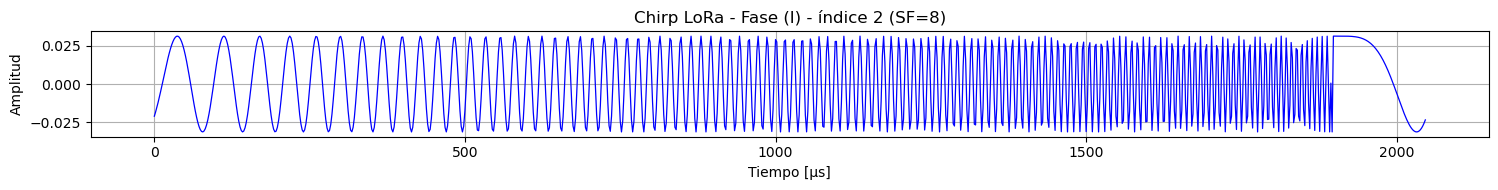

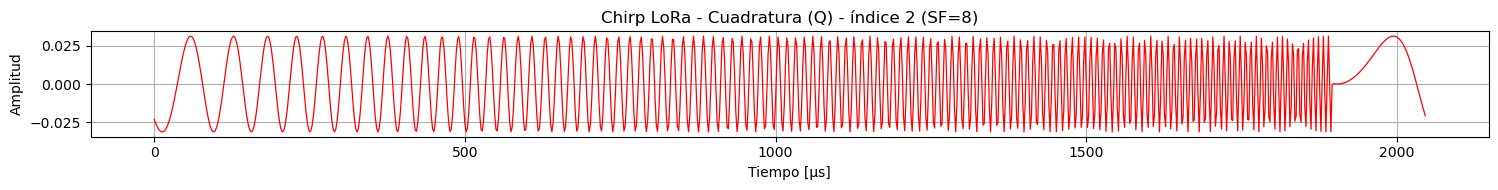

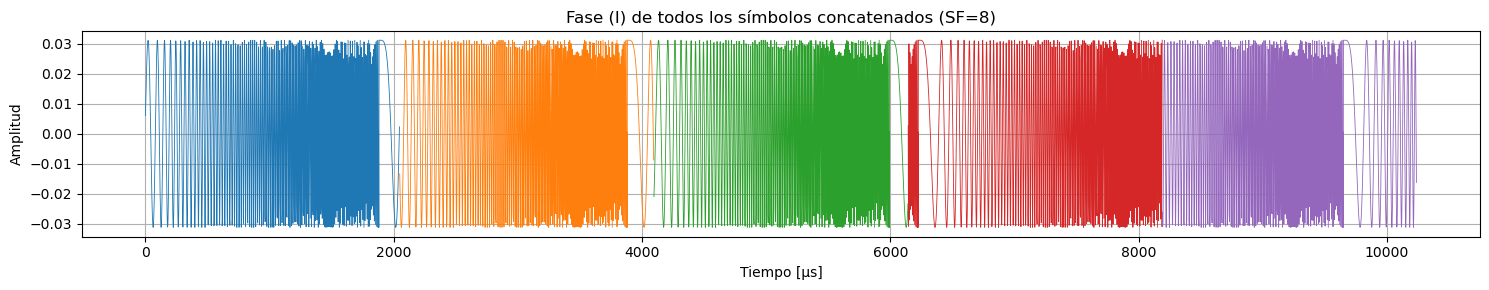

Símbolos codificados: [ 20  26  18 245  73 249  45   9 254 183]
Símbolos recibidos: [20, 26, 18, 245, 73, 249, 45, 9, 254, 183]
La tasa de error de simbolos (SER) es:  0.0


In [97]:
#Ejemplo de uso, continuando el ejemplo del capitulo anterior (Codificador y Decodificador)
#Configuración/Parametros
SF = 8                              # Spreading Factor (debe ser un valor entre 7 y 12)
cant_simbolos = 10                  # Cantidad de símbolos a transmitir             
total_bits = SF * cant_simbolos     # Total de bits a transmitir
B=125e3                             # Ancho de banda (en Hz)

samples_per_chirp = 4

simbolos_modulados = conformador_de_onda(simbolos_tx,SF,samples_per_chirp,B)
graficar_señal_modulada(simbolos_modulados,2,SF,samples_per_chirp,B)
graficar_todas_las_senales_moduladas(simbolos_modulados,SF,samples_per_chirp,B,5)
simbolos_rx = formador_de_ntuplas(simbolos_modulados, SF,samples_per_chirp)

print("Símbolos codificados:", simbolos_tx)
print("Símbolos recibidos:", simbolos_rx)

print("La tasa de error de simbolos (SER) es: ", calculador_ser(simbolos_tx, simbolos_rx))




# Canal

## Canales simulados

En este apartado se utilizara dos tipos de canales simulados con el fin de verificar y validar el funcionamiento del software realizado para posteriormente llevarlo a una implementancion en un canal real

### Canal aditivo plano

En este caso se simula un canal aditivo sin el componente de filtrado del canal, unicamente agrega ruido a la señal.

#### Obtencion de la potencia del ruido a partir de la SNR
La potencia de una señal aleatoria puede ser calculada como:

$$P_x = \mathbb{E}[|x|^2]$$

Desarrollando la expresion:

$$P_x=\mathbb{E}[(x - \mu +\mu)^2] =\mathbb{E}[(x - \mu)^2] + |\mu|^2 + 2\cdot \mathbb{E}[x - \mu]$$

Donde:

$2\cdot \mathbb{E}[x - \mu]=2\cdot (\mu-\mu)=0$ (por linealidad del valor esperado)

$\mathbb{E}[(x - \mu)^2]=Var(x)$

Entonces:

$$P_x = \mathbb{E}[|x|^2]=\text{Var}(x) + |\mu|^2$$

Si la media es cero ($\mu=0$):

$$P_x = \text{Var}(x)$$

In [ ]:
def canal_AWGN(signal, pot_ruido):
    """
    Simula un canal AWGN. Con media cero y varianza pot_ruido/2.
    """
    # el parametro que requiere la funcion random.normal es el desvio estandar, el cual es la raiz cuadrada de la potencia 
    # la potencia es divida en 2 porque el ruido es complejo (I y Q)
    desv_est = np.sqrt(pot_ruido / 2)
    ruido = np.random.normal(0, desv_est, size=signal.shape) + 1j * np.random.normal(0, desv_est, size=signal.shape)
    return (signal + ruido)



$$\large \text{SNR}_{dB}=10\cdot log(\frac{P_s}{P_n})\rightarrow P_n=\frac{P_s}{10^{\frac{\text{SNR}_{dB}}{10}}}$$

La potencia de la señal es obtenida a partir:

$$P_s = \mathbb{E}[|s|^2]$$

In [ ]:

def potencias_de_ruido(pot_signal, lim_inf=-12, lim_sup=0):
    """Calcula el rango de potencias de ruido en escala lineal para un rango de SNR en dB.

    Args:
        pot_signal (float): Potencia de la señal en escala lineal.
        lim_inf (int, optional): Valor de SNR inferior. Defaults to -12.
        lim_sup (int, optional): Valor de SNR superior. Defaults to -1.

    Returns:
        list: lista de SNR en dB
        list: lista de potencias de ruido.
    """
    snr_db = np.arange(lim_inf, lim_sup+1, 1)
    pot_ruido = pot_signal / (10 ** (snr_db / 10))
    return snr_db, pot_ruido


### Canal selectivo en frecuencia

El modelo de canal selectivo en frecuencia que propone Vangelista es un canal _multipath_ (de multiples trayectorias) lo que este canal modela es que la señal rebota en objetos del entorno (paredes, árboles, etc.) y llega al receptor con varios retardos y distintas potencias, de esta manera distorsiona la señal, porque introduce interferencia intersimbolo (ISI). La respuesta al impulso del canal matematicamente:

$$h[nT]=\sqrt{0.8}\cdot\delta[nT]+\sqrt{0.2}\cdot\delta[nT-T]$$

Cuya transformada de Fourier es:

$$H(f)=\sqrt{0.8}+\sqrt{0.2}\cdot e^{-j2\pi f T}$$

Donde $f=\frac{f_{real}}{f_s}$ (frecuencia normalizada)

Suponiendo $T=1$ tiempo normalizado

$$H(f)=\sqrt{0.8}+\sqrt{0.2}\cdot e^{-j2\pi f }$$

Se puede observar su efecto sobre señales para distintos valores de frecuencia:

|f|magnitud de H(f)| Efecto |
|:-:|:----:|:----:|
|0.25|1| Sin interferencia|
|0.5|0.45|Maxima atenuacion|
|0.75|1|Sin interferencia|
|1|1.34|Maxima amplificacion|

Como se puede observar el filtro del canal es un filtro rechaza-banda



In [100]:
def canal_multipath(signal_in, pot_ruido):
    """
    Aplica el filtro h[n] = sqrt(0.8)δ[n] + sqrt(0.2)δ[n−1] a cada chirp (fila) y
    agrega ruido. Se recorta para mantener la longitud original sin relleno artificial.

    Args:
        signal_in (np.ndarray): Array (n_chirps, total_muestras)
        pot_ruido (float): Potencia del ruido (lineal)

    Returns:
        np.ndarray: Señal con forma (n_chirps, total_muestras)
    """
    h = np.array([np.sqrt(0.8), np.sqrt(0.2)])
    chirps_filtrados = []

    for chirp in signal_in:
        chirp_filtrado = np.convolve(chirp, h, mode='full')[:len(chirp)]
        chirps_filtrados.append(chirp_filtrado)

    signal_filtrada = np.array(chirps_filtrados)

    # Agregar ruido complejo
    desv_est = np.sqrt(pot_ruido / 2)
    ruido = np.random.normal(0, desv_est, size=signal_filtrada.shape) + 1j * np.random.normal(0, desv_est, size=signal_filtrada.shape)

    return signal_filtrada + ruido


In [ ]:
def simulaciones_de_canal(bits_tx, SF, samples_per_chirp, B, min_snr_AWGN, max_snr_AWGN, min_snr_multipath, max_snr_multipath):
    """Simula el envio de bits a traves de un canal multipath, grafica la BER vs SNR 

    Args:
        bits_tx (list): Bits a transmitir.
        SF (int): Spreading Factor.
        samples_per_chirp (int): Muestras por chirp o factor de oversampling.
        B (int): Ancho de banda en Hz.
        min_snr (int): SNR mínima en dB.
        max_snr (int): SNR máxima en dB.
    """
    # 1. Codificacion
    simbolos_tx = codificador(bits_tx, SF)
    
    # 2. Modulacion
    simbolos_modulados = conformador_de_onda(simbolos_tx, SF, samples_per_chirp, B)
    
    # 3. Calcular potencia de la señal
    pot_signal = np.var(simbolos_modulados)+(np.mean(np.abs(simbolos_modulados)))**2
    
    # 4. Generar SNR y potencias de ruido
    snr_db_AWGN, pot_ruido_AWGN = potencias_de_ruido(pot_signal, min_snr_AWGN, max_snr_AWGN)
    snr_db_multipath, pot_ruido_multipath = potencias_de_ruido(pot_signal, min_snr_multipath, max_snr_multipath)

    # 5. Simular canal y demodular para cada SNR
    ber_values_AWGN = []
    ber_values_multipath = []
    
    for pn in pot_ruido_AWGN:
        simbolos_con_ruido_AWGN = canal_AWGN(simbolos_modulados, pn)
        
        simbolos_rx_AWGN = formador_de_ntuplas(simbolos_con_ruido_AWGN, SF, samples_per_chirp)
        
        bits_rx_AWGN = decodificador(simbolos_rx_AWGN, SF)
        
        ber_AWGN = calculador_ber(bits_tx, bits_rx_AWGN)
        
        ber_values_AWGN.append(ber_AWGN)
    
    for pn in pot_ruido_multipath:
        
        simbolos_con_ruido_multipath = canal_multipath(simbolos_modulados, pn)
        
        simbolos_rx_multipath = formador_de_ntuplas(simbolos_con_ruido_multipath, SF, samples_per_chirp)
        
        bits_rx_multipath = decodificador(simbolos_rx_multipath, SF)
        
        ber_multipath = calculador_ber(bits_tx, bits_rx_multipath)
        
        ber_values_multipath.append(ber_multipath)

    # 6. Graficar
    plt.figure(figsize=(6, 4))
    plt.semilogy(snr_db_AWGN, ber_values_AWGN, 's-r', label="Flat", linewidth=0.8)
    plt.semilogy(snr_db_multipath, ber_values_multipath, 'D-b', label="Freq. sel.", linewidth=0.8)
    plt.xlim(-12, -1)
    plt.ylim(10**-5, 10**-1)
    plt.xticks(np.arange(-12, 0, 1))
    plt.title('BER vs SNR')
    plt.xlabel('SNR [dB]')
    plt.ylabel('BER')
    plt.grid(True, linestyle="--", which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()


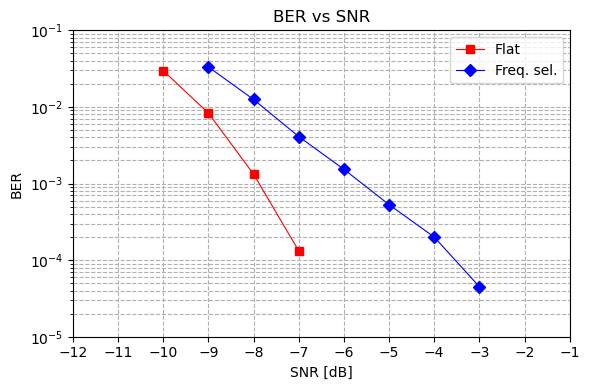

In [ ]:
#Ejemplo de uso:
#Configuración/Parametros
SF = 8
cant_simbolos = 50000
total_bits = SF * cant_simbolos
samples_per_chirp = 1
B=125e3

# Generación de bits aleatorios
bits_tx = generate_random_bits(total_bits)

# Simulación del canal AWGN y multipath y graficar BER vs SNR
simulaciones_de_canal(bits_tx, SF, samples_per_chirp, B, -10, -7, -9, -3)
